# Make synthetic data from the beta-binomial model and plot ABC SMC results

In [1]:
import numpy as np
import mystyle.sty as sty
import scipy.stats as ss
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as ss

In [2]:
sty.reset_plots()

# Make linear regression data

In [3]:
np.random.seed(1)

n_data = 30
x = np.linspace(0,10,n_data) + np.random.uniform(0,0.05,size=n_data)
gradient_truth = 1.0
intercept_truth = 122.0
sigma_truth = 2.0

y = gradient_truth*x + intercept_truth + np.random.normal(scale=sigma_truth, size=len(x))

data = np.vstack((x,y)).T

Text(0.5, 1.0, 'Data')

/home/juvid/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


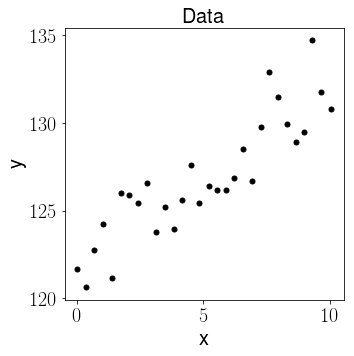

In [4]:
fig, ax = sty.plot()
ax.plot(x,y,'.k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Data')

In [5]:
np.savetxt('x.csv', data[:,0], fmt="%.8f")
np.savetxt('y.csv', data[:,1], fmt="%.8f")

In [6]:
prior_intercept_lower = prior_gradient_lower = prior_sigma_lower = 0
prior_intercept_upper = 500
prior_gradient_upper = 10
prior_sigma_upper = 10

In [7]:
lr = ss.linregress(data[:,0], data[:,1])
lr.slope, lr.intercept, np.sqrt(np.sum((data[:,1] - lr.slope*data[:,0]-lr.intercept)**2)/(len(data)-2))

(0.9982014701081334, 121.87154913978883, 1.632154675910165)

# Perform MCMC

In [8]:
linear_reg_model = pm.Model()
with linear_reg_model:
    # Regression coefs
    gradient = pm.Uniform('gradient', prior_gradient_lower, prior_gradient_upper)
    intercept = pm.Uniform('intercept', prior_intercept_lower, prior_intercept_upper)
    sigma = pm.Uniform('sigma', prior_sigma_lower, prior_sigma_upper)
    
    # Expected value
    mu = gradient*data[:,0] + intercept
       
    # Observation
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=data[:,1])

In [9]:
with linear_reg_model:
    trace = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, gradient]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:05<00:00, 2632.68draws/s]
The acceptance probability does not match the target. It is 0.8899212940048055, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8979998399633025, but should be close to 0.8. Try to increase the number of tuning steps.


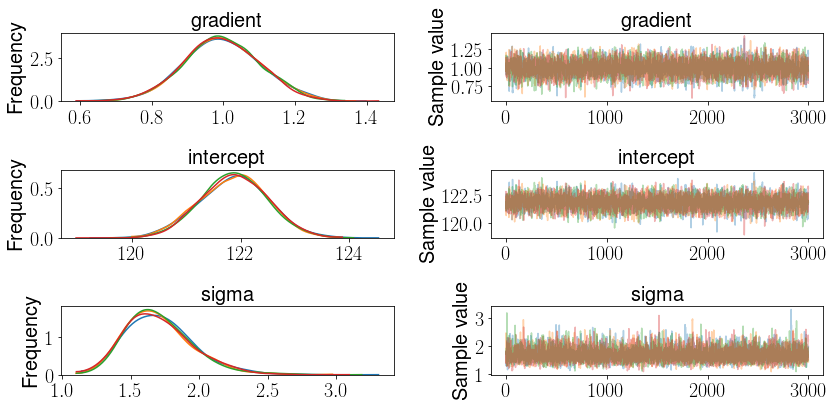

In [10]:
pm.plots.traceplot(trace);

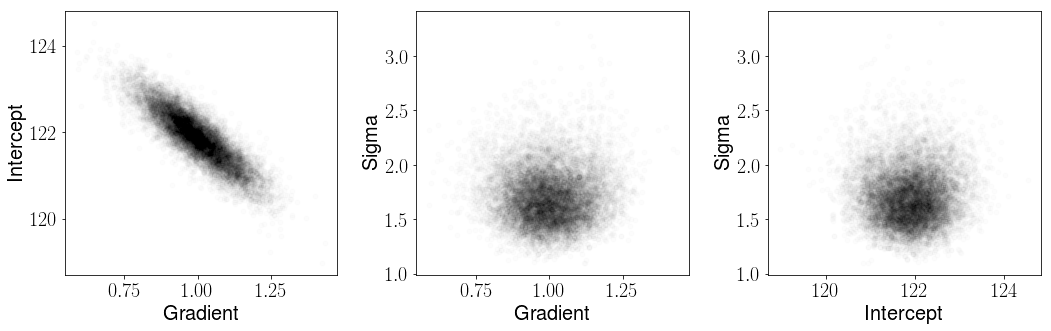

In [11]:
fig, axs = sty.plot(ncols=3)

ax = axs[0]
ax.plot(trace['gradient'], trace['intercept'], '.k', alpha=0.01)
ax.set_xlabel('Gradient')
ax.set_ylabel('Intercept')

ax = axs[1]
ax.plot(trace['gradient'], trace['sigma'], '.k', alpha=0.01)
ax.set_xlabel('Gradient')
ax.set_ylabel('Sigma')

ax = axs[2]
ax.plot(trace['intercept'], trace['sigma'], '.k', alpha=0.01)
ax.set_xlabel('Intercept')
ax.set_ylabel('Sigma')

plt.tight_layout()

## Load data from ABC SMC

In [12]:
gradients_smc = np.loadtxt('particle_0.csv', delimiter=',')
intercepts_smc = np.loadtxt('particle_1.csv', delimiter=',')
sigmas_smc = np.loadtxt('particle_2.csv', delimiter=',')

In [13]:
distances = np.loadtxt('distances.txt', delimiter=',')

In [14]:
n_particles, n_pop_smc = gradients_smc.shape

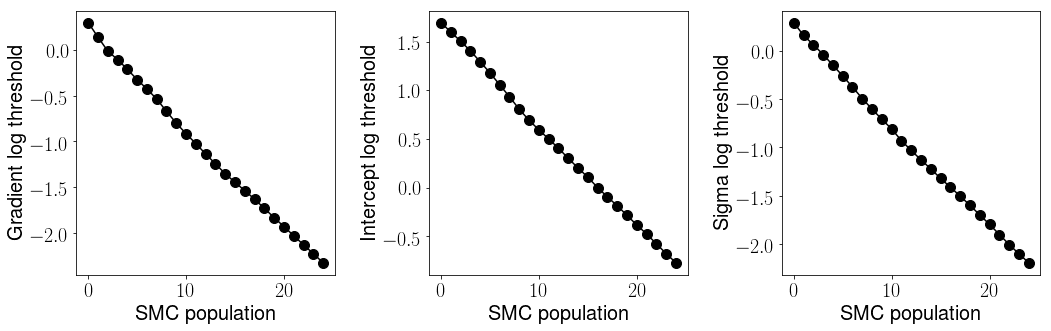

In [15]:
fig, axs = sty.plot(ncols=3)

ax = axs[0]
ax.plot(np.arange(n_pop_smc), np.log10(distances[0,:]), '-ok')
ax.set_xlabel('SMC population')
ax.set_ylabel('Gradient log threshold')

ax = axs[1]
ax.plot(np.arange(n_pop_smc), np.log10(distances[1,:]), '-ok')
ax.set_xlabel('SMC population')
ax.set_ylabel('Intercept log threshold')

ax = axs[2]
ax.plot(np.arange(n_pop_smc), np.log10(distances[2,:]), '-ok')
ax.set_xlabel('SMC population')
ax.set_ylabel('Sigma log threshold')

plt.tight_layout()

/home/juvid/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


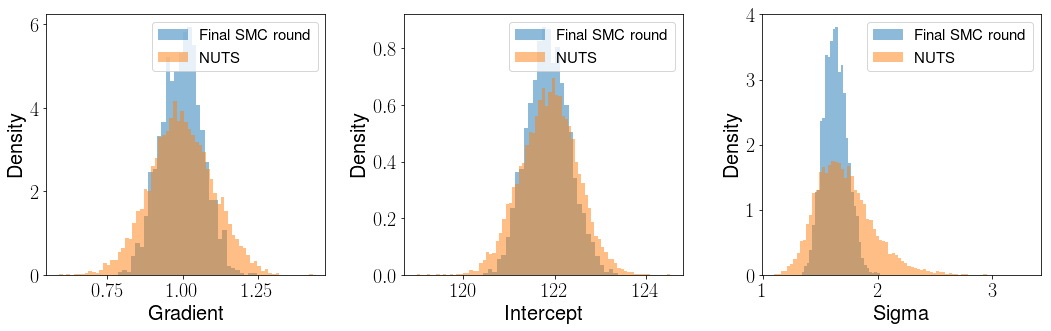

In [16]:
fig, axs = sty.plot(ncols=3)

ax = axs[0]
ax.hist(gradients_smc[:,-1], bins='auto', density=True, label=f'Final SMC round', alpha=0.5)
ax.hist(trace['gradient'], bins='auto', density=True, label='NUTS', alpha=0.5)
ax.legend()
ax.set_xlabel('Gradient')
ax.set_ylabel('Density')

ax = axs[1]
ax.hist(intercepts_smc[:,-1], bins='auto', density=True, label=f'Final SMC round', alpha=0.5)
ax.hist(trace['intercept'], bins='auto', density=True, label='NUTS', alpha=0.5)
ax.legend()
ax.set_xlabel('Intercept')
ax.set_ylabel('Density')

ax = axs[2]
ax.hist(sigmas_smc[:,-1], bins='auto', density=True, label=f'Final SMC round', alpha=0.5)
ax.hist(trace['sigma'], bins='auto', density=True, label='NUTS', alpha=0.5)
ax.legend()
ax.set_xlabel('Sigma')
ax.set_ylabel('Density')

plt.tight_layout()

The reason why the variance is smaller in SMC than NUTS is because the acceptance threshold on the distance metric is smaller than is warranted. There is some tuning which one must do in finding an appropriate set of $\epsilon_i$, and matching them to $\rho$.

It seems to me that, in this case, letting $\epsilon \rightarrow 0$ is just finding a maximum-likelihood estimate....?

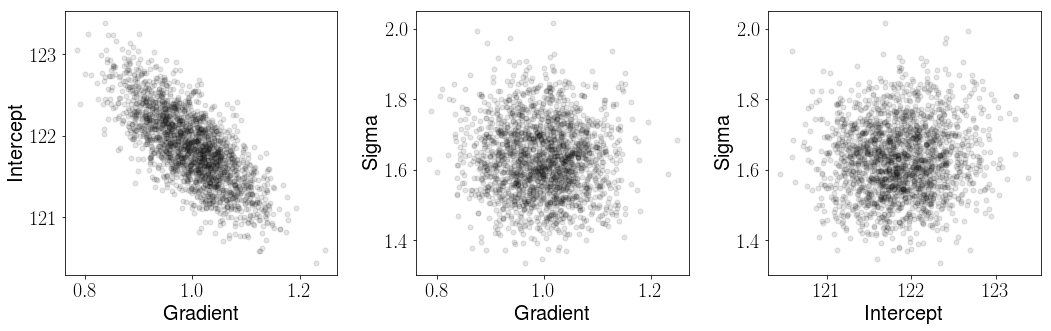

In [17]:
fig, axs = sty.plot(ncols=3)

ax = axs[0]
ax.plot(gradients_smc[:,-1], intercepts_smc[:,-1], '.k', alpha=0.1)
ax.set_xlabel('Gradient')
ax.set_ylabel('Intercept')

ax = axs[1]
ax.plot(gradients_smc[:,-1], sigmas_smc[:,-1], '.k', alpha=0.1)
ax.set_xlabel('Gradient')
ax.set_ylabel('Sigma')

ax = axs[2]
ax.plot(intercepts_smc[:,-1], sigmas_smc[:,-1], '.k', alpha=0.1)
ax.set_xlabel('Intercept')
ax.set_ylabel('Sigma')

plt.tight_layout()

SMC does, at least, appear to pick up on the covariance structure of the posterior.

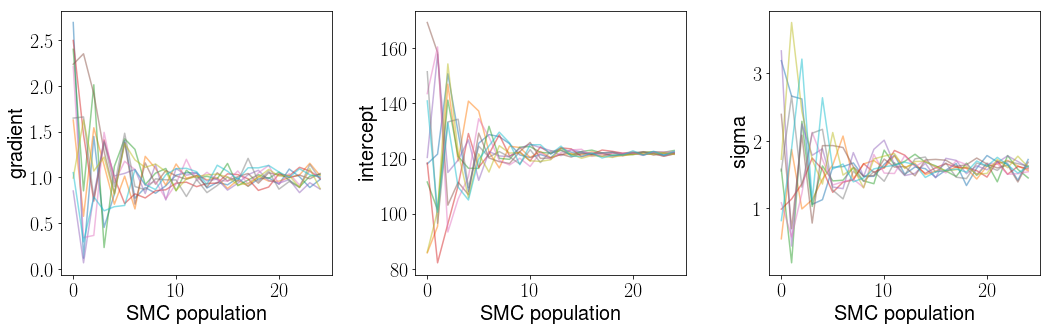

In [19]:
nrounds = gradients_smc.shape[-1]
theta_names = ['gradient', 'intercept', 'sigma']
fig, axs = sty.plot(ncols=3)

ax = axs[0]
for i in np.random.choice(10, size=10, replace=False):
    ax.plot(np.arange(nrounds), gradients_smc[i,:],'-', alpha=0.5)
ax = axs[1]
for i in np.random.choice(10, size=10, replace=False):
    ax.plot(np.arange(nrounds), intercepts_smc[i,:],'-', alpha=0.5)
ax = axs[2]
for i in np.random.choice(10, size=10, replace=False):
    ax.plot(np.arange(nrounds), sigmas_smc[i,:],'-', alpha=0.5)
for i, ax in enumerate(axs):
    ax.set_xlabel('SMC population')
    ax.set_ylabel(theta_names[i])
plt.tight_layout()

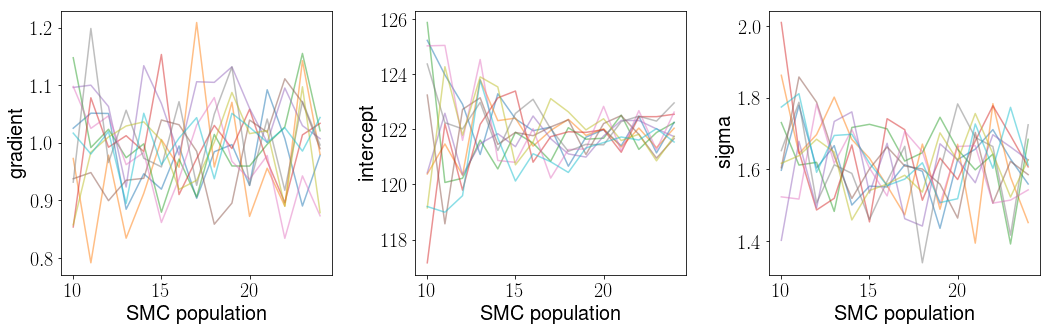

In [20]:
nrounds = gradients_smc.shape[-1]
theta_names = ['gradient', 'intercept', 'sigma']
fig, axs = sty.plot(ncols=3)

ax = axs[0]
for i in np.random.choice(10, size=10, replace=False):
    ax.plot(np.arange(10, nrounds), gradients_smc[i,10:],'-', alpha=0.5)
ax = axs[1]
for i in np.random.choice(10, size=10, replace=False):
    ax.plot(np.arange(10, nrounds), intercepts_smc[i,10:],'-', alpha=0.5)
ax = axs[2]
for i in np.random.choice(10, size=10, replace=False):
    ax.plot(np.arange(10, nrounds), sigmas_smc[i,10:],'-', alpha=0.5)
for i, ax in enumerate(axs):
    ax.set_xlabel('SMC population')
    ax.set_ylabel(theta_names[i])
plt.tight_layout()

There exists a range of distance thresholds for which the SMC populations look pretty similar.